# Backend Results

## Experiment 2 - Alternate Approach
- Seeing which algorithm **converges faster to cost ~ = 1**, given a particular unitary size and given number of max iterations 
- Iterations ranged from [5,20] with a change of 2 in between 
- Resolution is 30 and error threshold is $10^{-3}$

In [3]:
iterations = [i for i in range(5, 20, 2)]
iterations

[5, 7, 9, 11, 13, 15, 17, 19]

### Metrics Plotted
- The cost returned by the algorithm is plotted in each case 
- Along with cost, the average error from the **closest eigenvalue** is calculated.
- Note that each trial with ,say, $MAX$ iterations is executed 5 times to get a good estimate of the result. 

### Imports

In [3]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.extensions import UnitaryGate, Initialize
from qiskit.quantum_info import Statevector
from qiskit.tools.visualization import plot_bloch_vector
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from time import sleep
import sys
import os
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()

bogota = provider.get_backend('ibmq_bogota')
sim = Aer.get_backend('qasm_simulator')

In [4]:
from normal_SPEA import SPEA
from bundled_global_max_alt_SPEA import bundled_SPEA_alternate

### Plotter function

In [5]:
def generate_plots(unitary_size, costs, errors, overlaps, algorithm):

    colors = ['red', 'brown', 'cyan', 'green',
              'grey', 'blue', 'purple', 'black', 'orange']
    c1, c2, c3 = random.sample(colors, 3)

    # plot
    os.makedirs("Experiment_2/"+str(unitary_size) +
                "_qubit(random)(backend)/", exist_ok=True)
    # plot 1
    fig = plt.figure(figsize=(13, 6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_title(str(unitary_size)+" qubit "+algorithm +
                  " Cost v/s Max iters", fontsize=16)
    ax1.set_xlabel("Maximum iterations ", fontsize=15)
    ax1.set_ylabel("Metrics Returned for unitary ", fontsize=15)
    ax1.plot(iterations, costs, label='Costs of Unitary',
             marker='o', color=c1, alpha=0.7)
    ax1.plot(iterations, overlaps, label='Average overlap from nearest eigenvector',
             marker='s', color=c2, alpha=0.6)
    ax1.legend(loc='best')
    ax1.grid()
    # plot 2
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_title(str(unitary_size)+" qubit "+algorithm +
                  " % error v/s Max iters", fontsize=16)
    ax2.set_xlabel("Maximum iterations ", fontsize=15)
    ax2.set_ylabel("% error for nearest eigenvalue", fontsize=15)
    ax2.plot(iterations, errors, label='Average error from nearest eigenvalue',
             marker='o', color=c3, alpha=0.6)
    ax2.legend(loc='best')
    ax2.grid()
    # save axure
    fig.savefig("Experiment_2/"+str(unitary_size)+"_qubit(random)(backend)/" +
                algorithm+" Algorithm (alternate).JPG", dpi=200)

### Result Generator

In [6]:
def get_results(eig_vals, eig_vect, basis, basis_ind, unitary, algorithm, experiments):
    '''Return the results of running the algorithm for this particular unitary matrix'''
    costs_g = []
    errors_g = []
    max_overlaps_g = []
    # find how the cost converges with increasing iterations
    for iters in iterations:
        costs = []
        errors = []
        overlaps = []
        # run the experiments ...
        while len(costs) < experiments:
            if algorithm == 'original':
                spea = SPEA(unitary, resolution=30, error=3, max_iters=iters)
            else:
                spea = bundled_SPEA_alternate(
                    unitary, resolution=30, error=3, max_iters=iters)

            result = spea.get_eigen_pair(
                progress=False, backend=bogota, basis=basis, basis_ind=basis_ind,
                algo='alternate', randomize=False)

            if result['cost'] < 0.75:
                continue
            # find the costs
            costs.append(result['cost'])
            theta = result['theta']
            res_state = result['state']

            # find the abs difference in this theta with the closest eigenvalue
            # and append that to the errors ...
            min_error = 1e5
            for e in eig_vals:
                error = abs(e - theta)
                if error < min_error:
                    min_error = error
                    perc_error = ((error)/e)*100
            errors.append(perc_error)

            # find overlaps
            max_overlap = -1
            for k in eig_vect:
                dot = np.linalg.norm(np.dot(k, res_state.conjugate().T))**2
                max_overlap = max(max_overlap, dot)
            overlaps.append(max_overlap)

        print("Result with", iters, " iterations :")
        print("AVG. COST :", np.average(costs),
              "AVG. ERROR :", np.average(errors))
        # append the average result of your algorithm ...
        costs_g.append(np.average(costs))
        errors_g.append(np.average(errors))
        max_overlaps_g.append(np.average(overlaps))

    return costs_g, errors_g, max_overlaps_g

## 1 - qubit unitary

In [2]:
unit = unitary_group.rvs(2)
unit

NameError: name 'unitary_group' is not defined

- Generate actual eigenvalues to benchmark against.

In [46]:
eig_vals1, eig_vect1 = np.linalg.eig(unit)
eig_vals1 = np.angle(eig_vals1)
e = []
for k in eig_vals1:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals1 = np.array(e)
print("Eigenstates :", eig_vect1)
print("Eigenvalues :", eig_vals1)

Eigenstates : [[ 0.80266047+0.j         -0.59642408+0.00380595j]
 [ 0.59642408+0.00380595j  0.80266047+0.j        ]]
Eigenvalues : [0.49849375 0.78395833]


### Generate the Basis

In [ ]:
sample1 = unitary_group.rvs(2)
print(sample1)
basis1 = []
for k in sample1:
    basis1.append(np.array(k, dtype=complex))
print("1 qubit basis :", basis1)
ind1 = np.random.choice(range(2))
print(ind1)

#### Algorithm 1
- Given Approach

In [47]:
costs_1qubit_b, errors_eig_1qubit_b, max_overlaps_1qubit_b = get_results(
    eig_vals1, eig_vect1, basis1, ind1, unit, 'original', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.91015625 AVG. ERROR : 10.76000203277052
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.84296875 AVG. ERROR : 13.277393110459531
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimati

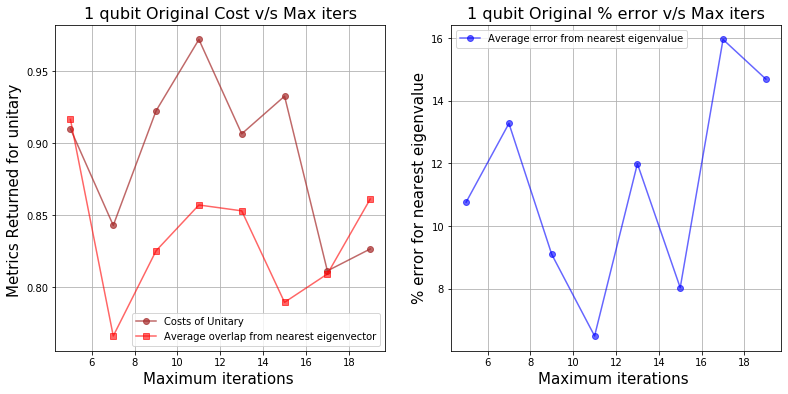

In [84]:
generate_plots(1, costs_1qubit_b, errors_1qubit_b,
               max_overlaps_1qubit_b, "Original")

#### Algorithm 2
- Randomized Approach 

In [63]:
costs_1qubit_c, errors_eig_1qubit_c, max_overlaps_1qubit_c = get_results(
    eig_vals1, eig_vect1, basis1, ind1, unit, 'modified', 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.71015625 AVG. ERROR : 23.11878894484486
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.898828125 AVG. ERROR : 15.32744859273665
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimati

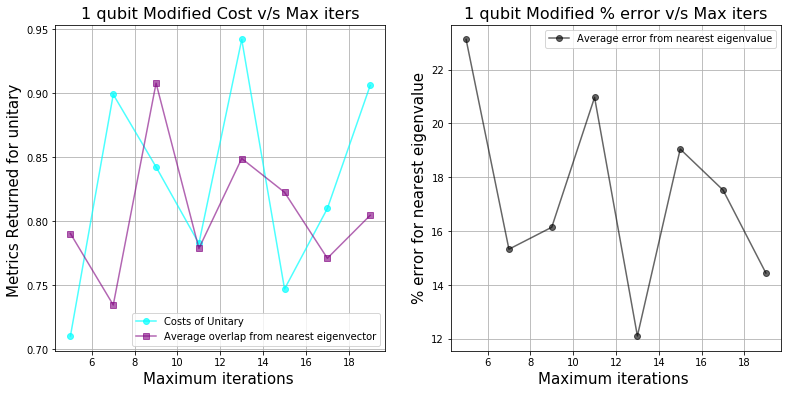

In [85]:
generate_plots(1, costs_1qubit_c, errors_1qubit_c,
               max_overlaps_1qubit_c, "Modified")

## 2 - qubit unitary


In [8]:
unit_2 = unitary_group.rvs(4)
unit_2

array([[-0.35827343+0.42995976j, -0.21512062+0.43220188j,
         0.3545285 +0.56891571j,  0.00281012+0.06584804j],
       [-0.06556259+0.53952195j,  0.33082648-0.55781943j,
        -0.1646906 +0.25265138j, -0.09161774-0.42972016j],
       [ 0.33476471-0.06631914j, -0.08992861-0.19751623j,
         0.0449846 +0.33851053j,  0.84669708+0.0540889j ],
       [-0.52432979-0.00223444j, -0.14412875-0.52767705j,
         0.49209598-0.31767483j,  0.15406845+0.24299028j]])

- Generating eigenvalues to benchmark against


In [9]:
eig_vals2, eig_vect2 = np.linalg.eig(unit_2)
eig_vals2 = np.angle(eig_vals2)
e = []
for k in eig_vals2:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals2 = np.array(e)
print("Eigenstates :", eig_vect2)
print("Eigenvalues :", eig_vals2)

Eigenstates : [[ 0.62644177+0.j          0.66788853+0.j         -0.3336242 +0.00939215j
   0.10390653+0.19825673j]
 [ 0.09658551+0.05744817j  0.29317173-0.16036825j  0.85637352+0.j
  -0.25228916+0.28049578j]
 [-0.52565268+0.30296876j  0.42821065-0.04663665j  0.07762552+0.08202496j
   0.65848769+0.j        ]
 [ 0.41331194-0.23667294j -0.21775451+0.45749416j  0.37387257+0.05192853j
   0.56229198-0.24039901j]]
Eigenvalues : [0.46578407 0.27041457 0.79805683 0.03258039]


### Generate the Basis

In [ ]:
sample2 = unitary_group.rvs(4)
print(sample2)
basis2 = []
for k in sample2:
    basis2.append(np.array(k, dtype=complex))
print("2 qubit basis :", basis2)
ind2 = np.random.choice(range(4))
print(ind2)

#### Algorithm 1

In [ ]:
costs_2qubit_b, errors_2qubit_b, max_overlaps_2qubit_b = get_results(eig_vals2,
                                                                     eig_vect2, basis2, ind2,
                                                                     unit_2, "original", 4)

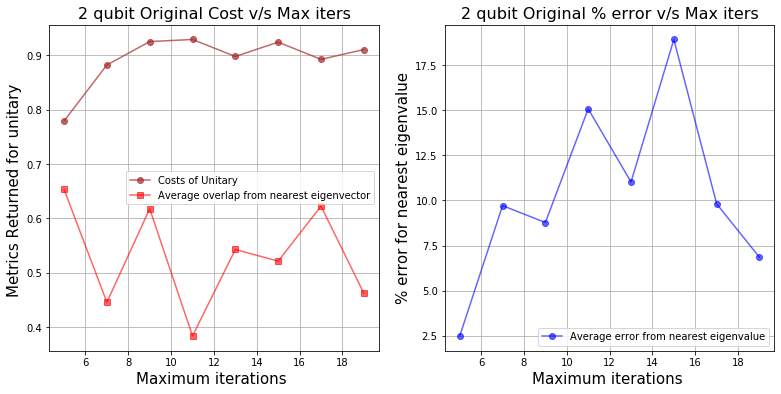

In [97]:
generate_plots(2, costs_2qubit_b, errors_2qubit_b,
               max_overlaps_2qubit_b, "Original")

#### Algorithm 2

In [98]:
costs_2qubit_c, errors_2qubit_c, max_overlaps_2qubit_c = get_results(
    eig_vals2, eig_vect2, basis2, ind2, unit_2, "modified", 4)

Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 5  iterations :
AVG. COST : 0.90966796875 AVG. ERROR : 4.746732130681569
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Result with 7  iterations :
AVG. COST : 0.92919921875 AVG. ERROR : 20.95797201362271
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the estimation.
Terminating algorithm...
Maximum iterations reached for the est

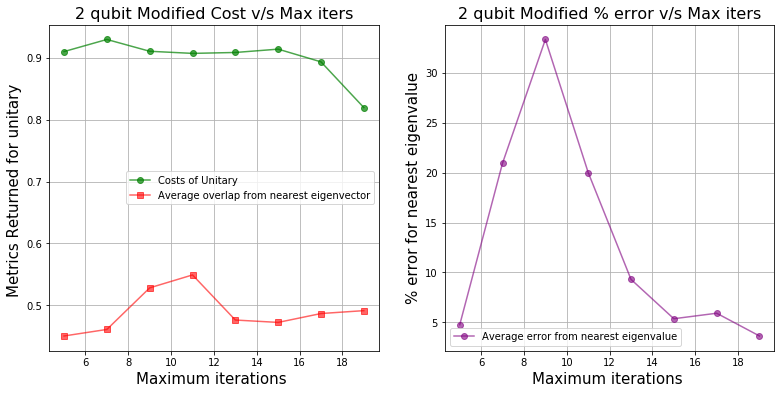

In [99]:
generate_plots(2, costs_2qubit_c, errors_2qubit_c,
               max_overlaps_2qubit_c, "Modified")

## 3 - qubit unitary

In [100]:
unit_3 = unitary_group.rvs(8)
unit_3

array([[ 0.12663367-0.3285733j ,  0.38181458+0.05116786j,
         0.15782808-0.51068097j, -0.21092516-0.28898796j,
        -0.19468101-0.00943876j, -0.1564849 -0.18853075j,
        -0.18370325+0.39574342j, -0.05328278+0.15058155j],
       [-0.06771478-0.10136196j, -0.34060279-0.3611785j ,
        -0.19832202-0.30914855j,  0.50907579-0.19078489j,
         0.04748941-0.43730231j, -0.08993347+0.18110199j,
        -0.24318887+0.03886616j,  0.03511249+0.10936181j],
       [ 0.40515061+0.31281621j,  0.23171915+0.18429359j,
        -0.31080266-0.38443814j,  0.13471916-0.1656231j ,
         0.00461396-0.018512j  ,  0.13288342+0.19502762j,
         0.41120201-0.26908722j, -0.23027419+0.09894888j],
       [ 0.52746188+0.12239056j,  0.1391557 -0.22342806j,
        -0.14741948+0.24630775j, -0.0465663 +0.13720911j,
        -0.02690303-0.28463885j, -0.08802479+0.07347696j,
        -0.01992391+0.43810563j, -0.00987787-0.49679371j],
       [ 0.03011389-0.12144664j, -0.35307236+0.06097447j,
        -0

In [101]:
eig_vals3, eig_vect3 = np.linalg.eig(unit_3)
eig_vals3 = np.angle(eig_vals3)
e = []
for k in eig_vals3:
    if k < 0:
        v = (k + 2*np.pi)/(2*np.pi)
    else:
        v = (k)/(2*np.pi)
    e.append(v)
eig_vals3 = np.array(e)
print("Eigenstates :", eig_vect3)
print("Eigenvalues :", eig_vals3)

Eigenstates : [[-0.15849685+0.40073516j -0.35162694+0.18351439j -0.04025295-0.12902663j
   0.01586999+0.1719672j   0.02568735-0.19162488j  0.19956592-0.29978217j
   0.63929833+0.j          0.18188913+0.00405688j]
 [-0.46637666-0.1254671j   0.34852843+0.29932987j  0.15812457+0.17046213j
   0.05601218+0.01665853j  0.0799784 +0.5071537j  -0.01683331-0.35844136j
   0.12995291-0.06417859j -0.13473269+0.2582252j ]
 [ 0.33128918+0.17957039j  0.61702363+0.j          0.19801729+0.02730264j
  -0.13772856-0.18802104j -0.16628413-0.15172039j  0.52109766+0.j
   0.16882212+0.14002269j  0.03499731+0.10706124j]
 [ 0.49242194+0.j         -0.13145236-0.11786295j -0.15987211+0.22701624j
   0.55368683+0.j          0.36502918+0.29791502j  0.10222353-0.04036578j
   0.13900231+0.17706259j -0.03900172+0.23751216j]
 [-0.04612093+0.02590686j  0.11575791+0.0429524j  -0.39881034-0.01012906j
  -0.20228836-0.08723451j  0.51643065+0.j          0.28193034-0.25191176j
  -0.12690632+0.00394974j -0.25163456-0.53403046j]

### Generate basis

In [ ]:
sample3 = unitary_group.rvs(8)
# print(sample3)
basis3 = []
for k in sample3:
    basis3.append(np.array(k,dtype=complex)) 
print("3 qubit basis :",basis3)
ind3 = np.random.choice(range(8))
print(ind3)

#### Algorithm 1

In [ ]:
costs_3qubit_b, errors_3qubit_b, max_overlaps_3qubit_b = get_results(
    eig_vals3, eig_vect3,basis3, ind3, unit_3, "original", 3)
generate_plots(3, costs_3qubit_c, errors_3qubit_c,
               max_overlaps_3qubit_c, "Original")

#### Algorithm 2

In [ ]:
costs_3qubit_c, errors_3qubit_c, max_overlaps_3qubit_c = get_results(
    eig_vals3, eig_vect3, basis3, ind3, unit_3, "modified", 3)
generate_plots(3, costs_3qubit_c, errors_3qubit_c,
               max_overlaps_3qubit_c, "Modified")

## 4 - qubit unitary

In [ ]:
unit_4 = unitary_group.rvs(16)
unit_4

- Algorithm 1

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = SPEA(unit_4, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])
    thetas.append(result['theta'])
# plot
plt.title("4-qubit(basic) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='red', alpha=0.5)
plt.plot(resolutions, thetas, label='Eigenvalues',
         marker='o', color='cyan', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/4_qubit/Basic Algorithm Result", dpi=200)

- Algorithm 2

In [ ]:
costs = []
thetas = []
# find how the cost converges with increasing resolution
for res in resolutions:
    spea = global_max_SPEA(unit_4, resolution=res, error=3, max_iters=10)
    result = spea.get_eigen_pair(progress=False, backend=casablanca)
    print("Result with", res, " resolution :", result)
    costs.append(result['cost'])
    thetas.append(result['theta'])

# plot
plt.title("4-qubit(modified) unitary cost v/s resolution", fontsize=16)
plt.xlabel("Resolution ", fontsize=15)
plt.ylabel("Cost Returned for unitary ", fontsize=15)
plt.plot(resolutions, costs, label='Costs of unitary',
         marker='s', color='yellow', alpha=0.7)
plt.plot(resolutions, thetas, label='Eigenvalues',
         marker='o', color='brown', alpha=0.5)
plt.legend()
plt.grid()
os.makedirs("SPE/Experiment_1/4_qubit/", exist_ok=True)
plt.savefig("SPE/Experiment_1/4_qubit/Modified Algorithm Result", dpi=200)